### Importing Libraries and Creating Game List of suggested games by developers

In [72]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import requests
from bs4 import BeautifulSoup

#list of games given to us by SlothKing
games_list = ['Ratz Instagib','The Riflemen', 'Party Animals', 'Crab Game', 'Bopl Battle', 'Worms W.M.D', 'Worms Rumble', 'Worms_Ultimate_Mayhem'] 
id_list = ['338170', '2022330', '1260320', '1782210', '1686940', '327030', '1186040', '70600']

gamedf = pd.DataFrame({'title': games_list, 'id': id_list})
gamedf


,title,id
0,Ratz Instagib,338170
1,The Riflemen,2022330
2,Party Animals,1260320
3,Crab Game,1782210
4,Bopl Battle,1686940
5,Worms W.M.D,327030
6,Worms Rumble,1186040
7,Worms_Ultimate_Mayhem,70600


### scrape the Genres and tags from the provided games list

In [73]:
def get_genres_and_tags(app_id):
    url = f"https://store.steampowered.com/app/{app_id}/"
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract genres (found under a specific div)
        genres_div = soup.find('div', {'class': 'details_block'})
        genres = []
        if genres_div:
            genre_links = genres_div.find_all('a', href=True)
            for genre in genre_links:
                if 'genre' in genre['href']:
                    genres.append(genre.text.strip())

        # Extract user tags (found under another div)
        tags_div = soup.find('div', {'class': 'glance_tags popular_tags'})
        tags = []
        if tags_div:
            tag_links = tags_div.find_all('a', {'class': 'app_tag'})
            tags = [tag.text.strip() for tag in tag_links]

    else:
        print(f"Error: {response.status_code}")
    return(genres, tags)


#
# Count the number of occurances of each genre or tag
#
gendict = {} 
tagdict = {}

all_gens = [] 
all_tags = []

for id in id_list:
    app_id = id
    gens, tags = get_genres_and_tags(app_id)
    
    #check if genre is already in gens if so increase its count by 1 if not add it and set its count to 1
    for gen in gens: 
        if gen not in gendict.keys():
            gendict[gen] = 1
        else: 
            gendict[gen] = gendict[gen] + 1

    #check if tag is already in tags if so increase its count by 1 if not add it and set its count to 1
    for tag in tags: 
        if tag not in tagdict.keys():
            tagdict[tag] = 1
        else: 
            tagdict[tag] = tagdict[tag] + 1


    #for wordcloud create a Total List of both gens and tags
    all_gens.extend(gens)
    all_tags.extend(tags)


In [74]:
gendict

{'Action': 7,
 'Indie': 4,
 'Casual': 3,
 'Free To Play': 2,
 'Racing': 1,
 'Strategy': 2}

In [75]:
tagRemoveList = []

for tag in tagdict: 
    if tagdict[tag] < 3: 
        tagRemoveList.append(tag)

tagdictSlimmed = tagdict
for tagRem in tagRemoveList: 
    tagdictSlimmed.pop(tagRem)

# list of tags that are not similar to sloth king
false_tags = ['First-Person', 'Singleplayer', 'Co-op', 'Online Co-Op', 'Local Multiplayer', 'Local Co-Op', 'Platformer', 'Strategy', 'FPS']
false_removed_tags = []
false_removed_tags = tagdictSlimmed

for t in false_tags:
    false_removed_tags.pop(t)

false_removed_tags

{'Action': 8,
 'Arena Shooter': 3,
 'Multiplayer': 8,
 'Shooter': 5,
 'Casual': 6,
 'Cartoony': 3,
 'PvP': 5,
 '3D': 3,
 'Funny': 5,
 'Physics': 3,
 'Comedy': 4}

In [76]:
gendict

{'Action': 7,
 'Indie': 4,
 'Casual': 3,
 'Free To Play': 2,
 'Racing': 1,
 'Strategy': 2}

### Tags Exploration

Graph of most common tags

Text(0, 0.5, 'count')

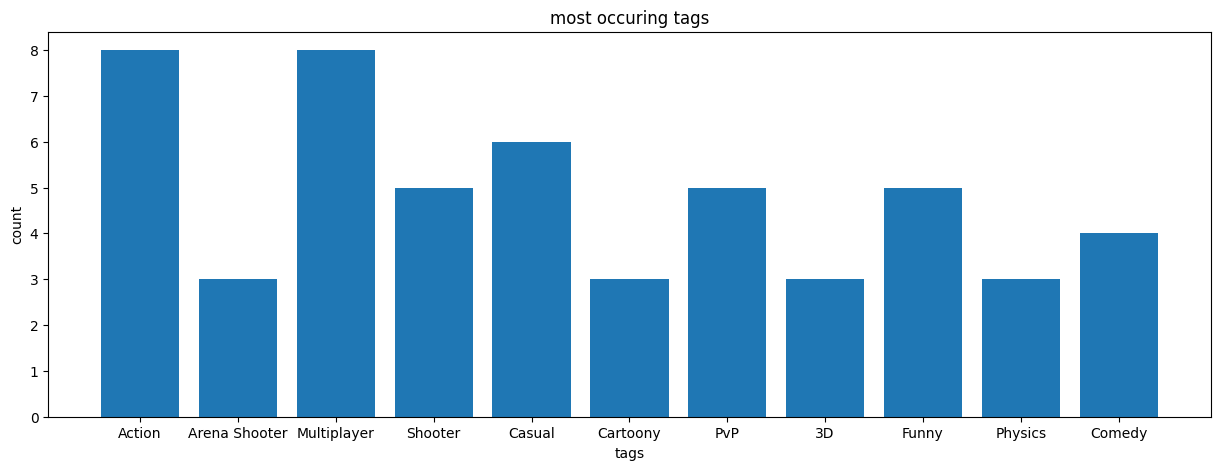

In [77]:
fig = plt.figure(figsize = (15, 5))
plt.bar(false_removed_tags.keys(), false_removed_tags.values())
plt.title("most occuring tags")
plt.xlabel("tags")
plt.ylabel("count")

Tags wordcloud

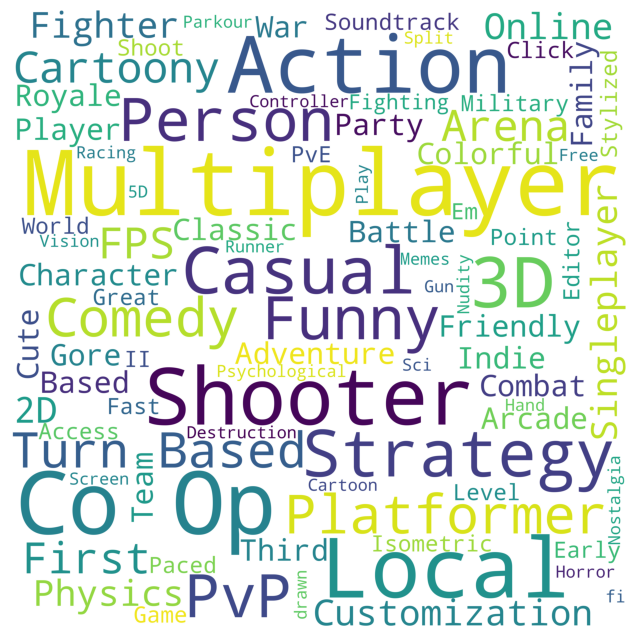

In [78]:
full_tags = "" 
for t in all_tags: 
    full_tags = full_tags + (t + " ")

tagcloud = WordCloud(width=4000, height=4000, 
                       background_color='white',
                       min_font_size=10).generate(full_tags)

plt.figure(figsize=(8,8))
plt.imshow(tagcloud)
plt.axis("off")
plt.show()

### Genres Exploration

Graph of most Common Genres

Text(0, 0.5, 'count')

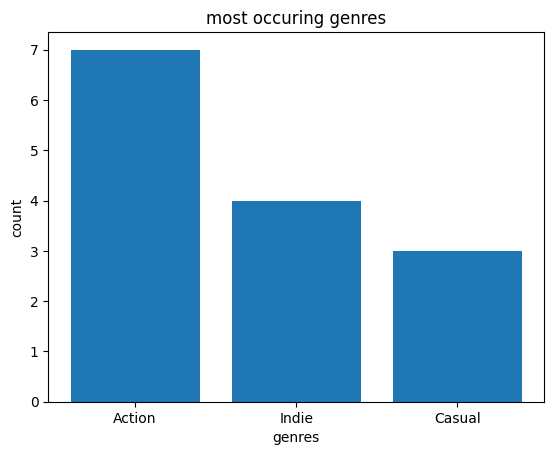

In [79]:
gendict2 = {}
for k in gendict.keys(): 
    if k not in ["Free To Play", "Racing", "Strategy"]: 
        gendict2[k] = gendict[k]

plt.bar(gendict2.keys(), gendict2.values())
plt.title("most occuring genres")
plt.xlabel("genres")
plt.ylabel("count")

genre wordcloud

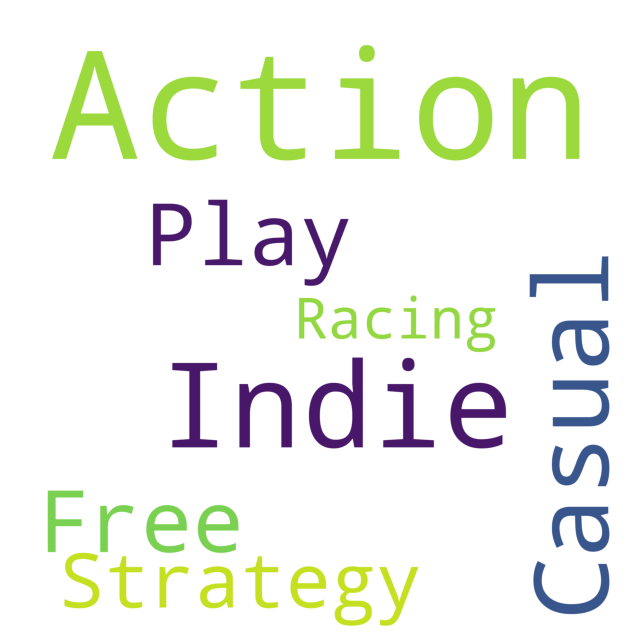

In [80]:
full_gens = "" 
for g in all_gens: 
    full_gens = full_gens + (g + " ")

genrecloud = WordCloud(width=4000, height=4000, 
                       background_color='white',
                       min_font_size=10).generate(full_gens)

plt.figure(figsize=(8,8))
plt.imshow(genrecloud)
plt.axis("off")
plt.show()

### Extracting a Larger List of Games

In [81]:
Titles = [] 
ids = [] 


# Steam URL for top sellers with Indie (492), Action (19), Casual (597), multiplayer(3859) and funny(4136) tags
url = "https://store.steampowered.com/search/?filter=topsellers&tags=492,19,597,3859,4136"

response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the page content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the game titles (adjust if Steam changes structure)
    filtered_games = soup.find_all('a', class_='search_result_row')
    
    # Print the top 10 filtered games
    for i, game in enumerate(filtered_games[:30]):
        Titles.append(game.find('span', class_='title').text)
        ids.append(game['href'].split('/')[4])

else:
    print("Failed to retrieve the Steam top sellers page")

GenreGames = pd.DataFrame({'title': Titles, 'id': ids})

In [82]:
GenreGames

,title,id
0,Bloons TD 6,960090
1,ShellShock Live,326460
2,Garry's Mod,4000
3,Party Animals,1260320
4,Pummel Party,880940
5,Wobbly Life,1211020
6,PICO PARK,1509960
7,Overcooked! 2,728880
8,Goose Goose Duck,1568590
9,Unrailed!,1016920


remove repeating games from the list

In [83]:
for id in GenreGames['id']:
    if id in gamedf['id']: 
        GenreGames =GenreGames.drop(id)

print((GenreGames))

                        title       id
0                 Bloons TD 6   960090
1             ShellShock Live   326460
2                 Garry's Mod     4000
3               Party Animals  1260320
4                Pummel Party   880940
5                 Wobbly Life  1211020
6                   PICO PARK  1509960
7               Overcooked! 2   728880
8            Goose Goose Duck  1568590
9                   Unrailed!  1016920
10             Project Winter   774861
11           Cat Goes Fishing   343780
12                 Overcooked   448510
13                      Biped  1071870
14            Human Fall Flat   477160
15                Bloons TD 5   306020
16         Who's Your Daddy?!   427730
17               Stumble Guys  1677740
18                   Pikuniku   572890
19                  Duck Game   312530
20  Project Winter - Blackout  1168030
21             Clicker Heroes   363970
22                 Moving Out   996770
23                   Broforce   274190
24               Clustert

Merge Game Data Frames

In [84]:
games = pd.concat([gamedf,GenreGames])
games = games.set_index('id')
games = games.sort_index()
games = games.drop_duplicates()
games

,title
id,
1016920,Unrailed!
1071870,Biped
1168030,Project Winter - Blackout
1186040,Worms Rumble
1211020,Wobbly Life
1260320,Party Animals
1509960,PICO PARK
1521580,Perfect Heist 2
1568590,Goose Goose Duck


In [85]:
games.to_csv("GamesList.csv")